In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [2]:
!nvidia-smi

Sun Sep  8 14:36:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [13]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [14]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 125], [True, 31354]]


In [15]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[30] * 2,
    batch_size=128,
)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 570.1295
Epoch: 002, Loss: 149.3068
Epoch: 003, Loss: 67.8120
Epoch: 004, Loss: 103.6667
Epoch: 005, Loss: 133.7367
Epoch: 006, Loss: 122.6373
Epoch: 007, Loss: 91.8785
Epoch: 008, Loss: 62.5413
Epoch: 009, Loss: 43.1910
Epoch: 010, Loss: 33.3824
Epoch: 011, Loss: 28.8169
Epoch: 012, Loss: 26.2299
Epoch: 013, Loss: 24.3398
Epoch: 014, Loss: 22.8210
Epoch: 015, Loss: 21.7033
Epoch: 016, Loss: 20.7997
Epoch: 017, Loss: 19.3897
Epoch: 018, Loss: 17.5876
Epoch: 019, Loss: 15.3626
Epoch: 020, Loss: 12.9687
Epoch: 021, Loss: 10.6787
Epoch: 022, Loss: 8.6938
Epoch: 023, Loss: 7.1492
Epoch: 024, Loss: 6.1085


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 5.3987
Epoch: 002, Loss: 4.9250
Epoch: 003, Loss: 4.5899
Epoch: 004, Loss: 4.2591
Epoch: 005, Loss: 3.9387
Epoch: 006, Loss: 3.6323
Epoch: 007, Loss: 3.3424
Epoch: 008, Loss: 3.0887
Epoch: 009, Loss: 2.8563
Epoch: 010, Loss: 2.6385
Epoch: 011, Loss: 2.4395
Epoch: 012, Loss: 2.2530
Epoch: 013, Loss: 2.0611
Epoch: 014, Loss: 1.8877
Epoch: 015, Loss: 1.7262
Epoch: 016, Loss: 1.5722
Epoch: 017, Loss: 1.4315
Epoch: 018, Loss: 1.3057
Epoch: 019, Loss: 1.2031
Epoch: 020, Loss: 1.1183
Epoch: 021, Loss: 1.0560
Epoch: 022, Loss: 1.0124
Epoch: 023, Loss: 0.9800
Epoch: 024, Loss: 0.9577
Epoch: 025, Loss: 0.9353
Epoch: 026, Loss: 0.9124
Epoch: 027, Loss: 0.8884
Epoch: 028, Loss: 0.8605
Epoch: 029, Loss: 0.8315
Epoch: 030, Loss: 0.8064
Epoch: 031, Loss: 0.7864
Epoch: 032, Loss: 0.7710
Epoch: 033, Loss: 0.7606
Epoch: 034, Loss: 0.7542
Epoch: 035, Loss: 0.7507
Epoch: 036, Loss: 0.7477
Epoch: 037, Loss: 0.7444
Epoch: 038, Loss: 0.7400
Epoch: 039, Loss: 0.7345
Epoch: 040, Loss: 0.7268


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6871
Epoch: 002, Loss: 0.6867
Epoch: 003, Loss: 0.6862
Epoch: 004, Loss: 0.6860
Epoch: 005, Loss: 0.6855
Epoch: 006, Loss: 0.6854
Epoch: 007, Loss: 0.6849
Epoch: 008, Loss: 0.6846
Epoch: 009, Loss: 0.6839
Epoch: 010, Loss: 0.6833
Epoch: 011, Loss: 0.6828
Epoch: 012, Loss: 0.6822
Epoch: 013, Loss: 0.6815
Epoch: 014, Loss: 0.6809
Epoch: 015, Loss: 0.6805
Epoch: 016, Loss: 0.6800
Epoch: 017, Loss: 0.6796
Epoch: 018, Loss: 0.6793
Epoch: 019, Loss: 0.6789
Epoch: 020, Loss: 0.6785
Epoch: 021, Loss: 0.6783
Epoch: 022, Loss: 0.6781
Epoch: 023, Loss: 0.6779
Epoch: 024, Loss: 0.6777


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6774
Epoch: 002, Loss: 0.6773
Epoch: 003, Loss: 0.6772
Epoch: 004, Loss: 0.6771
Epoch: 005, Loss: 0.6770
Epoch: 006, Loss: 0.6767
Epoch: 007, Loss: 0.6767
Epoch: 008, Loss: 0.6764
Epoch: 009, Loss: 0.6766
Epoch: 010, Loss: 0.6762
Epoch: 011, Loss: 0.6762
Epoch: 012, Loss: 0.6762
Epoch: 013, Loss: 0.6759
Epoch: 014, Loss: 0.6759
Epoch: 015, Loss: 0.6758
Epoch: 016, Loss: 0.6759
Epoch: 017, Loss: 0.6756
Epoch: 018, Loss: 0.6756
Epoch: 019, Loss: 0.6755
Epoch: 020, Loss: 0.6754
Epoch: 021, Loss: 0.6753
Epoch: 022, Loss: 0.6753
Epoch: 023, Loss: 0.6753
Epoch: 024, Loss: 0.6751
Epoch: 025, Loss: 0.6750
Epoch: 026, Loss: 0.6751
Epoch: 027, Loss: 0.6750
Epoch: 028, Loss: 0.6749
Epoch: 029, Loss: 0.6749
Epoch: 030, Loss: 0.6748
Epoch: 031, Loss: 0.6748
Epoch: 032, Loss: 0.6748
Epoch: 033, Loss: 0.6748
Epoch: 034, Loss: 0.6746
Epoch: 035, Loss: 0.6747
Epoch: 036, Loss: 0.6745
Epoch: 037, Loss: 0.6747
Epoch: 038, Loss: 0.6745
Epoch: 039, Loss: 0.6746
Epoch: 040, Loss: 0.6745


In [ ]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 5, Train: 0.8951652940043074, Val: 0.8909


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [16]:
z = get_emb(train_data)

In [17]:
z

array([[-3.3686717 ,  7.2450933 ,  0.14718454, ...,  2.3087945 ,
         3.3745885 , -4.8739204 ],
       [-0.90493846,  1.9462757 ,  0.03953874, ...,  0.6202198 ,
         0.9065278 , -1.3092992 ],
       [-1.0114801 ,  2.1754174 ,  0.04419375, ...,  0.69324034,
         1.0132565 , -1.4634476 ],
       ...,
       [-0.54464316,  1.1713787 ,  0.02379663, ...,  0.37328336,
         0.5455996 , -0.78801024],
       [-0.31122464,  0.6693593 ,  0.01359808, ...,  0.21330483,
         0.3117712 , -0.45029166],
       [-1.3818688 ,  2.9720223 ,  0.06037678, ...,  0.94709456,
         1.3842955 , -1.9993398 ]], dtype=float32)

In [ ]:
y= nodes_df['type'].astype('category').cat.codes

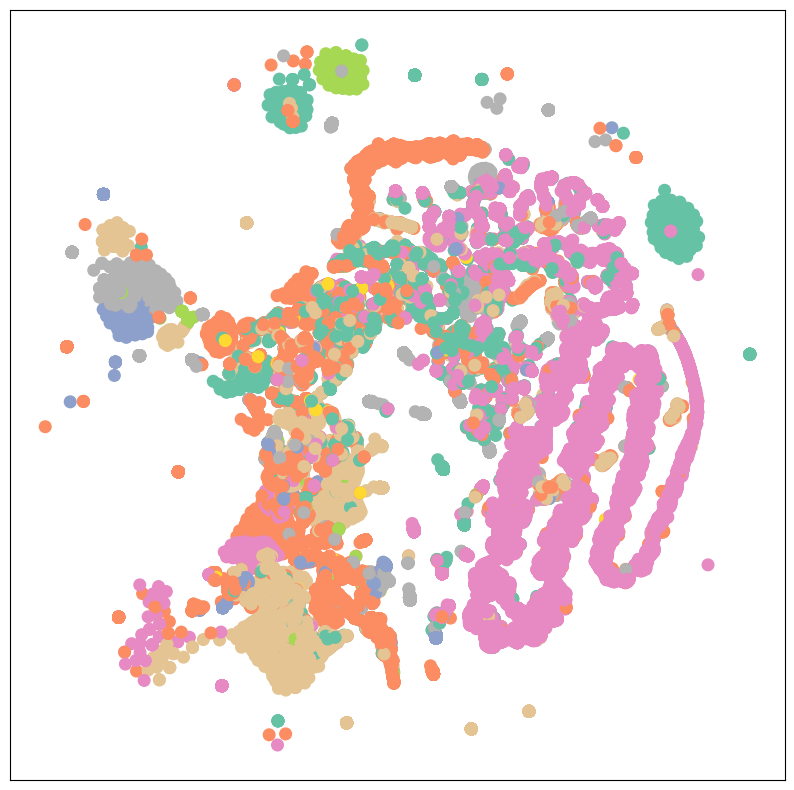

In [ ]:
visualize(z,y)

In [ ]:
torch.save(model, view_path+'GNConv_model_view'+str(view)+'.pth')

In [ ]:
import os

# Define the directory and file path
view =5
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNConv_predictions.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [ ]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNConv_predictions.csv')

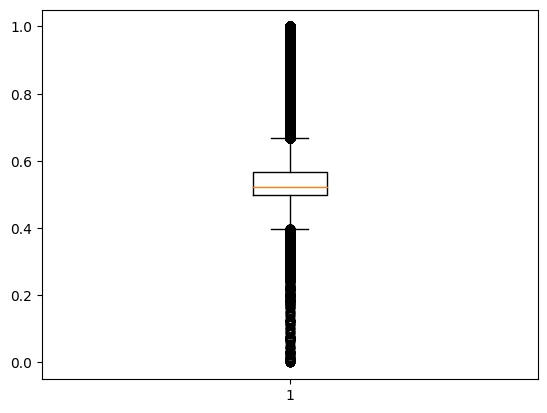

In [ ]:
_=plt.boxplot(get_prob(test_data))

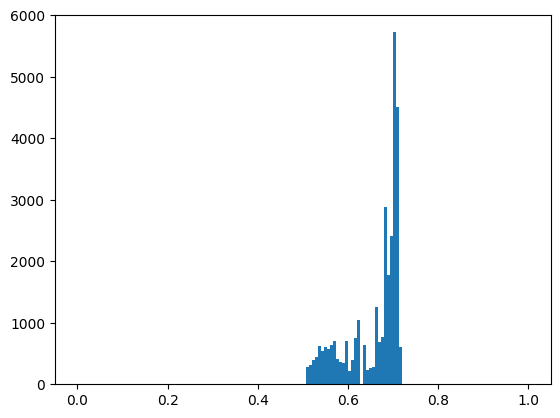

In [ ]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [18]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/1163>,Gene
1,<http://purl.obolibrary.org/obo/GO_1902115>,GO
2,<http://purl.obolibrary.org/obo/MONDO_0009301>,Disease
3,<http://www.ncbi.nlm.nih.gov/gene/2692>,Gene
4,<http://purl.obolibrary.org/obo/MONDO_0000535>,Disease
...,...,...
85294,<http://purl.obolibrary.org/obo/MONDO_0012718>,Disease
85295,<https://www.mirbase.org/mature/MIMAT0002841>,miRNA
85296,<http://purl.obolibrary.org/obo/GO_0102175>,GO
85297,<http://purl.obolibrary.org/obo/HP_0500107>,Phenotype


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8058
Precision: 0.8064
Recall: 0.8058


In [19]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [20]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [21]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [22]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [23]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,informedness,false_omission_rate,positive_likelyhood_ratio,markedness,diagnostic_odds_ratio,miss_rate,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,-0.003271,0.500847,0.909371,-0.024580,0.906295,0.967180,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,-0.020299,0.505210,0.438094,-0.200575,0.429058,0.984174,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,-0.003371,0.500873,0.907126,-0.025222,0.903963,0.967074,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,-0.020933,0.505372,0.422516,-0.208351,0.413534,0.984684,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,-0.003444,0.500891,0.904215,-0.026042,0.900997,0.967491,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,-0.019802,0.505080,0.440408,-0.199328,0.431549,0.984416,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,-0.003064,0.500793,0.914982,-0.022992,0.912083,0.967025,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,-0.021298,0.505466,0.416546,-0.211408,0.407537,0.984794,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,-0.003581,0.500927,0.900517,-0.027100,0.897184,0.967583,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,-0.020211,0.505187,0.438684,-0.200267,0.429676,0.984204,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


In [ ]:
from grape.embedders import Node2VecSkipGramEnsmallen


In [ ]:
plt.rcdefaults()
mpl.rcParams.update(mpl.rcParamsDefault)

size = 10
method = "TSNE"

# Embedding generation
start = time.time()
embedding=Node2VecSkipGramEnsmallen(
            #embedding_size=size,
            #return_weight=param[0],
            #explore_weight=param[1],
            #change_node_type_weight=param[2],
            #change_edge_type_weight=param[3],
            ).fit_transform(rna_kg_graph)
end = time.time()
print(f'Computed  in {end - start} s')

# Node visualization
vis = GraphVisualizer(
            graph=rna_kg_graph,
            automatically_display_on_notebooks=False,
            #node_embedding_method_name=,
            decomposition_method = method,
        )

vis.fit_nodes(embedding)


fig, ax = plt.subplots()
fig.suptitle("Size:"+str(size)+" Method: "+method, fontsize=16)
fig.tight_layout()

vis.plot_node_types(
        figure=fig,
        axes=ax,
        #axes=axes[index // ncols, index % ncols],
        #train_indices=train.get_node_ids_with_known_node_types(),
        #test_indices=test.get_node_ids_with_known_node_types()
        #show_legend=False,
        )


plt.show()